# BERT Model Training for Resume Classification

This notebook implements end-to-end BERT-based resume classification using the
preprocessed dataset. Tokenization and model training are performed within a
single notebook to maintain a clear and reproducible pipeline.

Tokenization parameters are fixed based on prior analysis and applied
consistently throughout model training and evaluation.


## Import Required Libraries


In [ ]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


## Load Preprocessed Dataset

The preprocessed dataset is loaded from disk. The dataset contains cleaned resume
text and corresponding category labels.


In [ ]:
!git clone https://github.com/chanmyae99/resume-bert-classification.git

Cloning into 'resume-bert-classification'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 104 (delta 32), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 1.64 MiB | 4.16 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [ ]:
%cd resume-bert-classification/notebooks

/content/resume-bert-classification/notebooks


In [ ]:
df = pd.read_csv("../data/preprocessed/CHAN_MYAE_AUNG_preprocessed.csv")
df.head()


,Category,Resume
0,Python Developer,technical skills languages python framework dj...
1,Health and fitness,education details january 2018 m s nutrition a...
2,Data Science,education details mca ymcaust faridabad haryan...
3,Network Security Engineer,operating systems windows linux ubuntu network...
4,Java Developer,education details be it pjlce java developer j...


In [ ]:
df.duplicated().sum()

np.int64(0)

## Encode Target Labels

Resume categories are encoded into numerical labels to enable model training.


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Category"])

df[["Category", "label"]].head()


,Category,label
0,Python Developer,20
1,Health and fitness,14
2,Data Science,6
3,Network Security Engineer,17
4,Java Developer,15


## Train–Validation Split

The dataset is split into training and validation sets to evaluate model
generalisation performance.


In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Resume"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


## BERT Tokenization for Resume Classification

This notebook performs tokenization of preprocessed resume text using the BERT
tokenizer. Tokenization converts textual data into numerical representations that
can be processed by the BERT model for downstream classification.


### Purpose of Tokenization

BERT does not process raw text directly. Instead, text must be transformed into
a fixed-length sequence of tokens and corresponding numerical IDs.

The purpose of tokenization is to:
- Split resume text into WordPiece subword tokens
- Convert tokens into numerical input IDs
- Generate attention masks for padded tokens
- Enforce a fixed input length required by BERT


### Choice of Tokenizer

The `bert-base-uncased` tokenizer is used in this project to ensure compatibility
with the pretrained BERT Base model.

This tokenizer:
- Converts all text to lowercase
- Applies WordPiece tokenization
- Uses the same vocabulary and token mappings as the pretrained model


### Maximum Token Length Constraint in BERT

BERT has a fixed maximum input length of 512 tokens. This limitation is imposed
by the model’s positional embedding architecture, which is defined during
pretraining.

The original BERT model was pretrained using a maximum sequence length of
512 tokens, and therefore cannot process longer input sequences without
truncation.

**Source of evidence:**
- Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). *BERT: Pre-training of
  Deep Bidirectional Transformers for Language Understanding*. NAACL-HLT.
- Hugging Face Transformers documentation: BERT configuration parameter
  `max_position_embeddings = 512`


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### WordPiece Tokenization

BERT uses WordPiece tokenization, which breaks words into subword units based on
a fixed vocabulary. This enables the model to handle rare or unseen words
effectively.

For example:
- "microservices" → ["micro", "##services"]
- "university" → ["university"]


In [ ]:
# Select a real resume from the dataset
sample_text = df["Resume"].iloc[0]

words = list(set(sample_text.split()))

# Limit to a small number for clarity
sample_words = words[20:30]

for word in sample_words:
    tokens = tokenizer.tokenize(word)
    print(f"{word} -> {tokens}")


requests -> ['requests']
selected -> ['selected']
technical -> ['technical']
responsibilities -> ['responsibilities']
information -> ['information']
participated -> ['participated']
s -> ['s']
environment -> ['environment']
managent -> ['manage', '##nt']
added -> ['added']


### Token Length Analysis for Maximum Length Selection

Before selecting a maximum token length, it is necessary to analyse the number
of tokens produced by the BERT tokenizer for each resume. This ensures that the
chosen `max_length` is data-driven and minimises unnecessary truncation while
maintaining computational efficiency.


In [ ]:
# Compute token length for each resume
token_lengths = df["Resume"].apply(
    lambda x: len(tokenizer.tokenize(x))
)

token_lengths.describe()


,Resume
count,218.000000
mean,461.288991
std,390.286594
min,19.000000
25%,184.250000
50%,344.500000
75%,616.000000
max,2316.000000


In [ ]:
# Inspect extreme cases
print("Shortest resume token length:", token_lengths.min())
print("Longest resume token length:", token_lengths.max())
print("95th percentile token length:", token_lengths.quantile(0.95))


Shortest resume token length: 19
Longest resume token length: 2316
95th percentile token length: 1240.3999999999996


### Justification of Selected Maximum Token Length

Token length analysis indicates that resume documents are substantially longer
than typical short-text classification inputs. The median token length is
approximately 370 tokens, while the mean exceeds 500 tokens.

Given this distribution and the architectural constraint of BERT, a maximum
token length of 512 tokens was selected to preserve the majority of resume
content and minimise information loss due to truncation.



In [ ]:
MAX_LENGTH = 512


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding="max_length",
    max_length=MAX_LENGTH,
    return_attention_mask=True,
    return_tensors="pt"
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding="max_length",
    max_length=MAX_LENGTH,
    return_attention_mask=True,
    return_tensors="pt"
)



### Tokenization Outputs

The tokenizer generates the following tensors:

- `input_ids`: Numerical token identifiers representing WordPiece tokens
- `attention_mask`: Binary mask indicating which tokens are valid (1) and padded (0)

These tensors form the input to the BERT classification model.


In [ ]:
print("input_ids shape:", train_encodings["input_ids"].shape)
print("attention_mask shape:", train_encodings["attention_mask"].shape)


input_ids shape: torch.Size([174, 512])
attention_mask shape: torch.Size([174, 512])


### Special Tokens Confirmation

Each tokenized sequence includes:
- `[CLS]` token at the beginning (used for classification)
- `[SEP]` token marking the end of the sequence
- `[PAD]` tokens for padding shorter sequences

This structure follows the standard input format required by BERT Base.


In [ ]:
# Inspect tokens for a sample resume
sample_ids = train_encodings["input_ids"][0]
sample_tokens = tokenizer.convert_ids_to_tokens(sample_ids)

sample_tokens[:30]


['[CLS]',
 'computer',
 'skills',
 'holder',
 'of',
 'valid',
 'ks',
 '##a',
 'license',
 'basic',
 'computer',
 'ms',
 'office',
 'auto',
 '##ca',
 '##d',
 '2006',
 '##ed',
 '##uca',
 '##tion',
 'details',
 'january',
 '2005',
 'diploma',
 'bengal',
 '##uru',
 'karnataka',
 'oxford',
 'polytechnic',
 'bang']

## Dataset and DataLoader Preparation

Tokenized inputs and labels are wrapped into PyTorch datasets and loaded using
DataLoader for efficient batch processing.


In [ ]:
train_dataset = TensorDataset(
    train_encodings["input_ids"],
    train_encodings["attention_mask"],
    torch.tensor(train_labels)
)

val_dataset = TensorDataset(
    val_encodings["input_ids"],
    val_encodings["attention_mask"],
    torch.tensor(val_labels)
)

train_loader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8
)

val_loader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8
)


## BERT Model Initialisation

A pretrained BERT Base model is loaded and adapted for multi-class resume
classification.


In [ ]:
num_labels = df["label"].nunique()

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Optimizer Configuration

The AdamW optimizer is used, which is recommended for fine-tuning transformer
models.


In [ ]:
import torch.optim as optim
optimizer = optim.AdamW(model.parameters(), lr=2e-5)


## Model Training

The model is trained for a fixed number of epochs. Validation accuracy is
computed after each epoch.


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 8

for epoch in range(epochs):
    # -------- TRAINING --------
    model.train()
    total_loss = 0
    train_preds, train_true = [], []

    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        train_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        train_true.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_acc = accuracy_score(train_true, train_preds)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}/{epochs} - Training loss: {avg_train_loss:.4f}, Training accuracy: {train_acc:.4f}")

    # -------- VALIDATION --------
    model.eval()
    val_preds, val_true = [], []
    val_loss_total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            val_loss_total += outputs.loss.item()
            logits = outputs.logits

            val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    avg_val_loss = val_loss_total / len(val_loader)
    val_losses.append(avg_val_loss)

    val_acc = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_acc)

    print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_acc:.4f}")



Epoch 1/8 - Training loss: 2.4389, Training accuracy: 0.4138
Validation loss: 2.3532, Validation accuracy: 0.3182
Epoch 2/8 - Training loss: 2.2187, Training accuracy: 0.5575
Validation loss: 2.1388, Validation accuracy: 0.5227
Epoch 3/8 - Training loss: 1.8868, Training accuracy: 0.7759
Validation loss: 1.8394, Validation accuracy: 0.6591
Epoch 4/8 - Training loss: 1.6200, Training accuracy: 0.8851
Validation loss: 1.5719, Validation accuracy: 0.7955
Epoch 5/8 - Training loss: 1.3659, Training accuracy: 0.9023
Validation loss: 1.3889, Validation accuracy: 0.8409
Epoch 6/8 - Training loss: 1.1735, Training accuracy: 0.9483
Validation loss: 1.2035, Validation accuracy: 0.8182
Epoch 7/8 - Training loss: 0.9604, Training accuracy: 0.9598
Validation loss: 1.0359, Validation accuracy: 0.8182
Epoch 8/8 - Training loss: 0.8066, Training accuracy: 0.9770
Validation loss: 0.9095, Validation accuracy: 0.8636


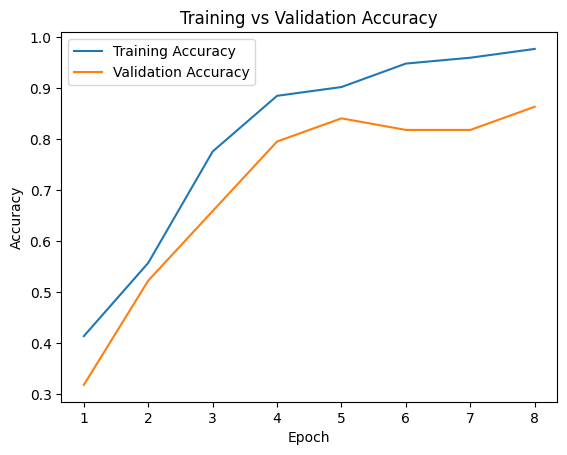

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_accuracies) + 1)

plt.figure()
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


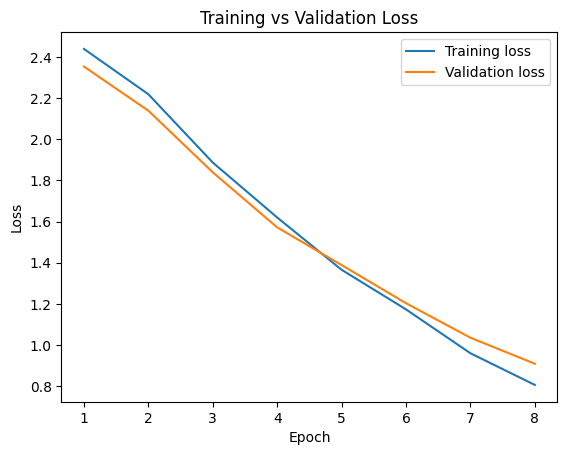

In [ ]:
epochs = range(1, len(val_losses) + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Training loss")
plt.plot(epochs, val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


## Model Evaluation

The trained model is evaluated using accuracy and per-class performance metrics.


In [ ]:
print(
    classification_report(
        val_true,
        val_preds,
        target_names=label_encoder.classes_,
        zero_division=0
    )
)



                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         2
                     Arts       1.00      1.00      1.00         2
       Automation Testing       1.00      0.50      0.67         2
               Blockchain       1.00      1.00      1.00         2
         Business Analyst       0.00      0.00      0.00         1
           Civil Engineer       1.00      1.00      1.00         1
             Data Science       1.00      0.50      0.67         2
                 Database       1.00      1.00      1.00         2
          DevOps Engineer       0.50      0.50      0.50         2
         DotNet Developer       0.00      0.00      0.00         1
            ETL Developer       1.00      1.00      1.00         2
   Electrical Engineering       1.00      1.00      1.00         1
                       HR       1.00      1.00      1.00         2
                   Hadoop       1.00      1.00      1.00     

## Summary

This notebook implemented an end-to-end BERT-based resume classification
pipeline, including tokenization, model training, and evaluation. Tokenization
parameters were fixed based on prior analysis, and the pretrained BERT Base model
was fine-tuned on the resume dataset.
